# Generate MNIST and CIFAR10 

In [148]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Part 1: Sampler

In [149]:
class Sampleable(ABC):
    # distributions to be sampled from
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
            - labels: shape (batch_size,)
        """
        pass

class IsotropicGaussian(nn.Module, Sampleable):
    def __init__(self, shape: List[int], std: float = 1.0):
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

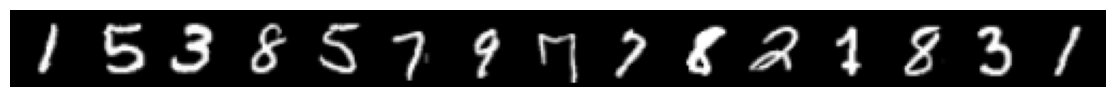

In [150]:
class MNISTSampler(nn.Module, Sampleable):
    def __init__(self):
        super().__init__()
        self.dataset = datasets.MNIST(
            root = "./data_mnist",
            train = True,
            download = True,
            transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),                              # to tensor of [0, 1]
                transforms.Normalize(mean=(0.5, ), std=(0.5, ))     # (x - 0.5) / 0.5 = 2x - 1 [-1, 1]
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1))

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(*[self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy.device)
        labels = torch.tensor(labels).to(self.dummy.device)
        return samples, labels

mnist_sampler = MNISTSampler()
mnist_images, mnist_label = mnist_sampler.sample(15)                  # [-1, 1]
mnist_images = (1 + mnist_images) / 2                                 # [0, 1] so that make_grid can handle it correctly
mnist_grid_image = make_grid(mnist_images, nrow=15)
mnist_grid_image = mnist_grid_image.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(1 * 15, 1))
plt.imshow(mnist_grid_image)
plt.axis('off')
plt.show()

Files already downloaded and verified


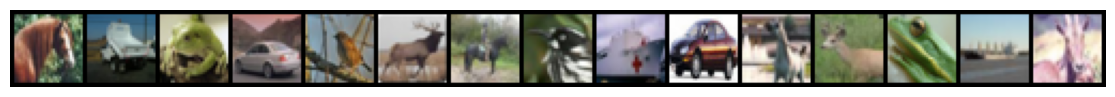

In [151]:
class CIFAR10Sampler(nn.Module, Sampleable):
    def __init__(self):
        super().__init__()
        self.dataset = datasets.CIFAR10(
            root = "./data_cifar10",
            train = True,
            download = True,
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1))
    
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(*[self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy.device)
        labels = torch.tensor(labels).to(self.dummy.device)
        return samples, labels
    
cifar10_sampler = CIFAR10Sampler()
cifar10_images, cifar10_labels = cifar10_sampler.sample(15)
cifar10_images = (1 + cifar10_images) / 2
cifar10_grid_image = make_grid(cifar10_images, nrow=15)
cifar10_grid_image = cifar10_grid_image.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(1 * 15, 1))
plt.imshow(cifar10_grid_image)
plt.axis("off")
plt.show()

## Part 2: Probability Path

In [152]:
class ConditionalProbabilityPath(nn.Module, ABC):
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # returns: z, y = shape(num_samples, c, h, w), shape(num_samples, )
        return self.p_data.sample(num_samples)

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # get position form the p_t(x|z), z: shape(bs, c, h, w), t: shape(bs, 1, 1, 1)
        # returns: shape(bs, c, h, w)
        pass
    
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # get the velocity given position x, condition z and time t
        # x: shape(bs, c, h, w), z: shape(bs, c, h, w), t: shape(bs, 1, 1, 1)
        # returns: shape(bs, c, h, w)
        pass

In [153]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return (vmap(jacrev(self)) (t.unsqueeze(1))).view(-1, 1, 1, 1)
    
class Beta(ABC):
    def __init__(self):
        assert torch.allclose(self(torch.zeros(1, 1, 1, 1)), torch.ones(1, 1, 1, 1))
        assert torch.allclose(self(torch.ones(1, 1, 1, 1)), torch.zeros(1, 1, 1, 1))

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return (vmap(jacrev(self)) (t.unsqueeze(1))).view(-1, 1, 1, 1)
    
class LinearAlpha(Alpha):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return torch.ones_like(t)
    
class LinearBeta(Beta):
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return 1 - t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1, 1, 1)
        return - torch.ones_like(t)

In [154]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape=p_simple_shape, std=1.0)
        super().__init__(p_data=p_data, p_simple=p_simple)
        self.alpha = alpha
        self.beta = beta
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # z: shape(bs, c, h, w), t: shape(bs, 1, 1, 1)
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), z: shape(bs, c, h, w), t: shape(bs, c, h, w)
        alpha_t = self.alpha(t)         # (bs, 1, 1, 1)
        beta_t = self.beta(t)           # (bs, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t)   # (bs, 1, 1, 1)
        dt_beta_t = self.beta.dt(t)     # (bs, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

## Part 3: Vector Field and Simulator

In [155]:
class VectorField(ABC): 
    @abstractmethod
    def velocity(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        # xt: the position at time t, shape(bs, c, h, w); t: shape(bs, 1, 1, 1)
        pass

class NNVectorField(nn.Module, ABC):
    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # returns u_t^theta(x | y), shape(bs, c, h, w)
        pass

class CFGVectorField(VectorField):
    def __init__(self, net: NNVectorField, guidance_sclae: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_sclae

    def velocity(self, xt: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        guided_velocity = self.net(xt, t, y)
        unguided_y = torch.ones_like(y) * 10
        unguided_velocity = self.net(xt, t, unguided_y)
        return self.guidance_scale * guided_velocity + (1 - self.guidance_scale) * unguided_velocity

In [156]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        # xt: shape(bs, c, h, w), t: shape(bs, 1, 1, 1), dt: shape(bs, 1, 1, 1)
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs) -> torch.Tensor:
        # x_init: shape(bs, c, h, w), ts: shape(bs, nts, 1, 1, 1), returns: shape(bs, c, h, w)
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x
    
class EulerSimulator(Simulator):
    def __init__(self, vectorfield: VectorField):
        self.vectorfield = vectorfield
    
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs) -> torch.Tensor:
        return xt + self.vectorfield.velocity(xt, t, **kwargs) * dt

## Part 4: NN Struture

In [157]:
class FourierEncoder(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.freqs = nn.Parameter(torch.randn(1, self.half_dim))        # shape(1, half_dim)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(bs, 1, 1, 1)
        t = t.view(-1, 1)                                               # shape(bs, 1)
        theta = t * self.freqs * 2 * math.pi                            # shape(bs, half_dim)
        sin_embed = torch.sin(theta)                                    # shape(bs, half_dim)
        cos_embed = torch.cos(theta)                                    # shape(bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # shape(bs, dim)

In [158]:
class AdaptLayer(nn.Module):
    def __init__(self, channels: int, t_embed_dim: int, y_embed_dim: int):
        super().__init()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(num_features=channels),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(num_features=channels),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        )
        self.t_adapter = nn.Sequential(
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.SiLU(),
            nn.Linear(t_embed_dim, channels)
        )
        self.y_adapter = nn.Sequential(
            nn.Linear(y_embed_dim, y_embed_dim),
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )
    
    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t_embed: shape(bs, t_embed_dim), y_embed: shape(bs, y_embed_dim)
        x_origin = x.clone()
        x = self.block1(x)

        t_adapted = self.t_adapter(t_embed).unsqueeze(-1).unsqueeze(-1)     # shape(bs, c, 1, 1)
        x += t_adapted
        y_adapted = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1)     # shape(bs, c, 1, 1)
        x += y_adapted

        x = self.block2(x)                                                  # shape(bs, c, h, w)
        x += x_origin
        return x

In [159]:
class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_adapt_layer: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.adapt_blocks = nn.ModuleList([
            AdaptLayer(channels=channels_in, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim) for _ in range(num_adapt_layer)
        ])
        self.downsample = nn.Conv2d(in_channels=channels_in, out_channels=channels_out, kernel_size=3, stride=2, padding=1)
        # out_dim = floor((in_dim + 2 * padding - kernel_size + 1) / stride) = floor(in_dim / 2)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t_embed: shape(bs, t_embed_dim), y_embed: shape(bs, y_embed_dim)
        for block in self.adapt_blocks:
            x = block(x, t_embed, y_embed)
        x = self.downsample(x)
        return x
    
class Midcoder(nn.Module):
    def __init__(self, channels: int, num_adapt_layer: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.adapt_blocks = nn.ModuleList([
            AdaptLayer(channels=channels, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim) for _ in range(num_adapt_layer)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t_embed: shape(bs, t_embed_dim), y_embed(bs, y_embed_dim)
        for block in self.adapt_blocks:
            x = block(x, t_embed, y_embed)
        return x
    
class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_adapt_layer: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=channels_in, out_channels=channels_out, kernel_size=3, padding=1)
        )
        self.adapt_blocks = nn.ModuleList(
            AdaptLayer(channels=channels_in, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim) for _ in range(num_adapt_layer)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t_embed: shape(bs, t_embed_dim), y_embed: shape(bs, y_embed_dim)
        x = self.upsample(x)
        for block in self.adapt_blocks:
            x = block(x, t_embed, y_embed)
        return x

In [160]:
class UNetVectorField(NNVectorField):
    def __init__(self, num_channels: int, layer_channels: List[int], num_adapt_layer: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=layer_channels[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=layer_channels[0]),
            nn.SiLU()
        )
        self.t_embedder = FourierEncoder(dim=t_embed_dim)
        self.y_embedder = nn.Embedding(num_embeddings=11, embedding_dim=y_embed_dim)

        encoders = []
        decoders = []
        for (curr, next) in zip(layer_channels[:-1], layer_channels[1:]):
            encoders.append(Encoder(channels_in=curr, channels_out=next, num_adapt_layer=num_adapt_layer, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim))
            decoders.append(Decoder(channels_in=next, channels_out=curr, num_adapt_layer=num_adapt_layer, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder = Midcoder(channels=layer_channels[-1], num_adapt_layer=num_adapt_layer, t_embed_dim=t_embed_dim, y_embed_dim=y_embed_dim)

        self.final_conv = nn.Conv2d(in_channels=layer_channels[0], out_channels=num_channels, kernel_size=3, padding=1)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # x: shape(bs, c, h, w), t: shape(bs, 1, 1, 1), y: shape(bs,)
        res = []
        t_embed = self.t_embedder(t)
        y_embed = self.y_embedder(y)
        x = self.init_conv(x)

        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed)
            res.append(x.clone())

        x = self.midcoder(x)

        for decoder in self.decoders:
            x_res = res.pop()
            x += x_res
            x = decoder(x, t_embed, y_embed)

        x = self.final_conv(x)

        return x     

## Part 5: Training Wraper

In [161]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> torch.Tensor:
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)
    
    def train(self, num_epochs: int, device: torch.device, name: str, lr: float=1e-3, **kwargs):
        # print the model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')

        # start
        self.model.to(device)
        opt = self.get_optimizer(lr=lr)
        self.model.train()
        losses = []

        # train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            losses.append(loss.item())
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')
        
        # finish
        self.model.eval()

        save_dir = "./result"
        os.makedirs(save_dir, exist_ok=True)
        
        # visualize the loss curve
        plt.figure()
        plt.plot(losses, label="Train Loss")
        plt.yscale("log")
        plt.title(f"{name} Loss Curve")
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{name}_loss.png"))

        # save the parameters
        torch.save(self.model.state_dict(), os.path.join(save_dir, f"{name}_model.pth"))

In [162]:
class CFGTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, net: NNVectorField, eta: float, **kwargs):
        assert (eta <= 1) and (eta >= 0)
        super().__init__(model=net, **kwargs)
        self.path = path
        self.eta = eta

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        z, y = self.path.sample_conditioning_variable(batch_size)   # z: shape(bs, c, h, w), y: shape(bs,)

        mask = torch.rand(batch_size).to(y.device)
        y[mask < self.eta] = 10.0

        t = torch.rand(batch_size, 1, 1, 1).to(y.device)
        xt = self.path.sample_conditional_path(z, t)

        u_t_ref = self.path.conditional_vector_field(xt, z, t)      # shape(bs, c, h, w)
        u_t_theta = self.net(xt, t, y)                              # shape(bs, c, h, w)

        error = torch.einsum("bchw -> b", torch.square(u_t_ref - u_t_theta))    # shape(bs, )
        return torch.mean(error)